In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [62]:
tracker = EmissionsTracker(measure_power_secs=1, output_dir="data/", output_file="carbon_log.csv")
tracker.start()

[codecarbon WARNING @ 20:45:20] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:45:20] [setup] RAM Tracking...
[codecarbon INFO @ 20:45:20] [setup] CPU Tracking...
[codecarbon WARNING @ 20:45:22] We saw that you have a Intel(R) Core(TM) Ultra 5 125H but we don't know it. Please contact us.
[codecarbon WARNING @ 20:45:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 20:45:22] CPU Model on constant consumption mode: Intel(R) Core(TM) Ultra 5 125H
[codecarbon WARNING @ 20:45:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:45:22] [setup] GPU Tracking...
[codecarbon INFO @ 20:45:22] No GPU found.
[codecarbon INFO @ 20:45:22] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
 

In [63]:
# Read cleaned daily data
pm25_daily = pd.read_csv("data/pm2.5_cleaned.csv")
pm25_daily['Date'] = pd.to_datetime(pm25_daily['Date'])

# Set index
pm25_daily.set_index('Date', inplace=True)

# Ensure daily frequency
pm25_daily = pm25_daily.asfreq('D')

# Interpolate missing values (if any)
pm25_daily['PM2.5'] = pm25_daily['PM2.5'].interpolate(method='linear')


In [64]:
pm25_monthly = pm25_daily.resample('M').mean()

C:\Users\Bjqhm\AppData\Local\Temp\ipykernel_6452\2442936366.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pm25_monthly = pm25_daily.resample('M').mean()


# Visualization

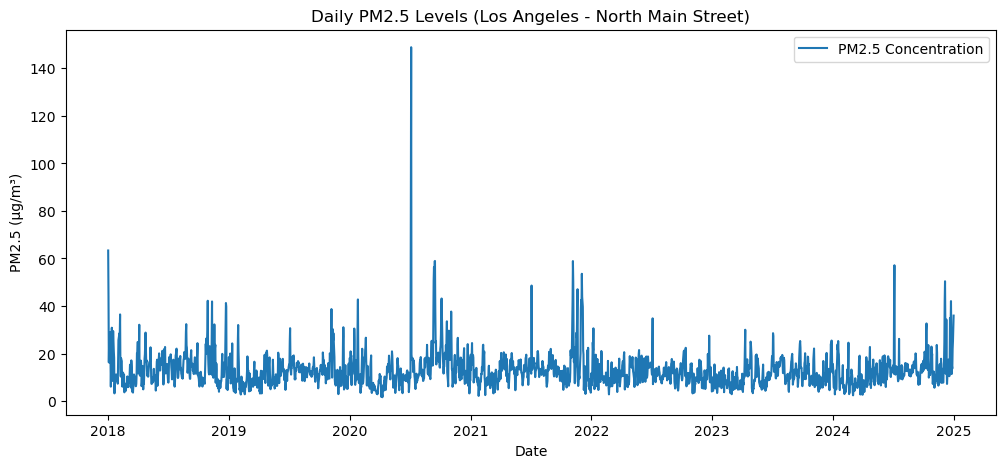

In [65]:
# Plot PM2.5 over time
plt.figure(figsize=(12, 5))
plt.plot(pm25_daily.index, pm25_daily["PM2.5"], label="PM2.5 Concentration")
plt.title("Daily PM2.5 Levels (Los Angeles - North Main Street)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

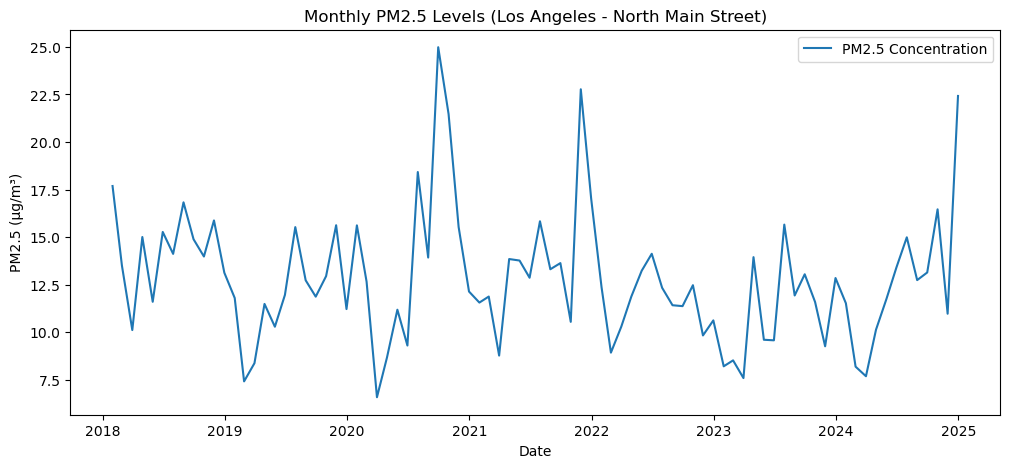

In [66]:
plt.figure(figsize=(12, 5))
plt.plot(pm25_monthly.index, pm25_monthly["PM2.5"], label="PM2.5 Concentration")
plt.title("Monthly PM2.5 Levels (Los Angeles - North Main Street)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.show()

# Statistical Model

[codecarbon INFO @ 20:45:23] Energy consumed for RAM : 0.000006 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:23] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:23] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 20:45:23] 0.000018 kWh of electricity used since the beginning.


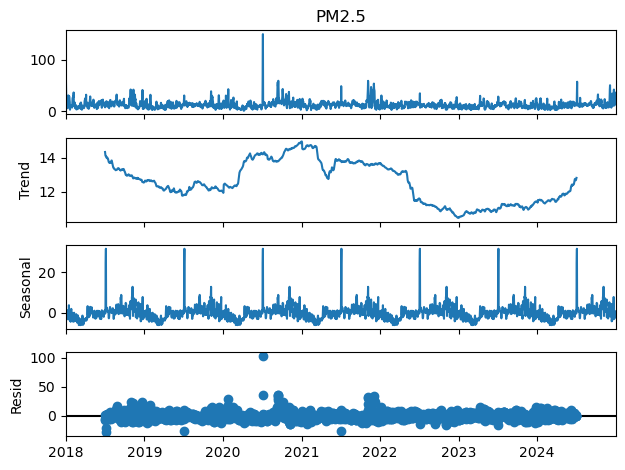

[codecarbon INFO @ 20:45:24] Energy consumed for RAM : 0.000011 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:24] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:24] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 20:45:24] 0.000035 kWh of electricity used since the beginning.


In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(pm25_daily["PM2.5"], model="additive", period=365)
decomp.plot()
plt.show()


In [68]:
# Daily
n_daily = len(pm25_daily)
train_daily = pm25_daily.iloc[:int(n_daily*0.8)]
test_daily  = pm25_daily.iloc[int(n_daily*0.8):]

# Monthly
n_monthly = len(pm25_monthly)
train_monthly = pm25_monthly.iloc[:int(n_monthly*0.8)]
test_monthly  = pm25_monthly.iloc[int(n_monthly*0.8):]


## Train Model

In [69]:
# Daily ARIMA
sarima_daily = ARIMA(train_daily['PM2.5'], order=(5,0,4), trend='c')
sarima_daily_fit = sarima_daily.fit()

# Monthly ARIMA
sarima_monthly = ARIMA(train_monthly['PM2.5'], order=(1,0,0),trend='c')
sarima_monthly_fit = sarima_monthly.fit()


c:\Users\Bjqhm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Bjqhm\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[codecarbon INFO @ 20:45:25] Energy consumed for RAM : 0.000017 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:25] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:25] Energy consumed for All CPU : 0.000036 kWh
[codecarbon INFO @ 20:45:25] 0.000052 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:26] Energy consumed for RAM : 0.000022 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:26] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:26] Energy consumed for All CPU : 0.000047 kWh
[codecarbon INFO @ 20:45:27] 0.000069 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:27] Energy consumed for RAM : 0.000027 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:28] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:28] Energy consumed for All CPU : 0.000059 kWh
[codecarbon INFO @ 20:45:28] 0.000086 kWh 

## Test Model

In [70]:
# Daily
pred_daily = sarima_daily_fit.forecast(steps=len(test_daily))

# Monthly
pred_monthly = sarima_monthly_fit.forecast(steps=len(test_monthly))


In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Daily
rmse_daily = root_mean_squared_error(test_daily['PM2.5'], pred_daily)
mae_daily  = mean_absolute_error(test_daily['PM2.5'], pred_daily)

# Monthly
rmse_monthly = root_mean_squared_error(test_monthly['PM2.5'], pred_monthly)
mae_monthly  = mean_absolute_error(test_monthly['PM2.5'], pred_monthly)

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

mape_daily = mape(test_daily['PM2.5'], pred_daily)
mape_monthly = mape(test_monthly['PM2.5'], pred_monthly)

print("Daily RMSE:", rmse_daily, "MAE:", mae_daily, "MAPE:", mape_daily)
print("Monthly RMSE:", rmse_monthly, "MAE:", mae_monthly, "MAPE:", mape_monthly)



Daily RMSE: 6.485427234164288 MAE: 4.672731230261804 MAPE: 50.47119702579628
Monthly RMSE: 3.364242273492494 MAE: 2.4090764797609374 MAPE: 20.65686006582958


[codecarbon INFO @ 20:45:31] Energy consumed for RAM : 0.000043 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:31] Delta energy consumed for CPU with constant : 0.000011 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:31] Energy consumed for All CPU : 0.000093 kWh
[codecarbon INFO @ 20:45:31] 0.000136 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:31] 0.006165 g.CO2eq/s mean an estimation of 194.43383403977649 kg.CO2eq/year


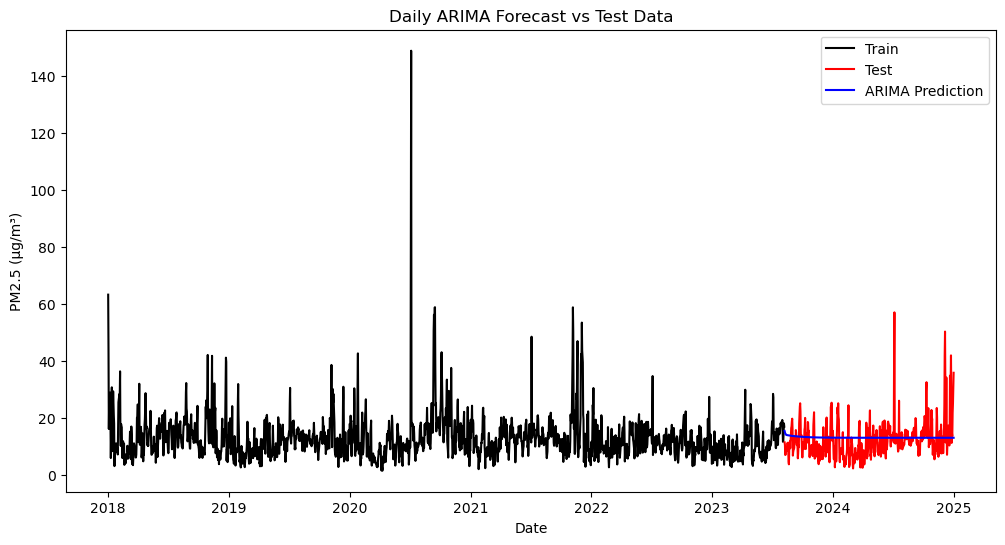

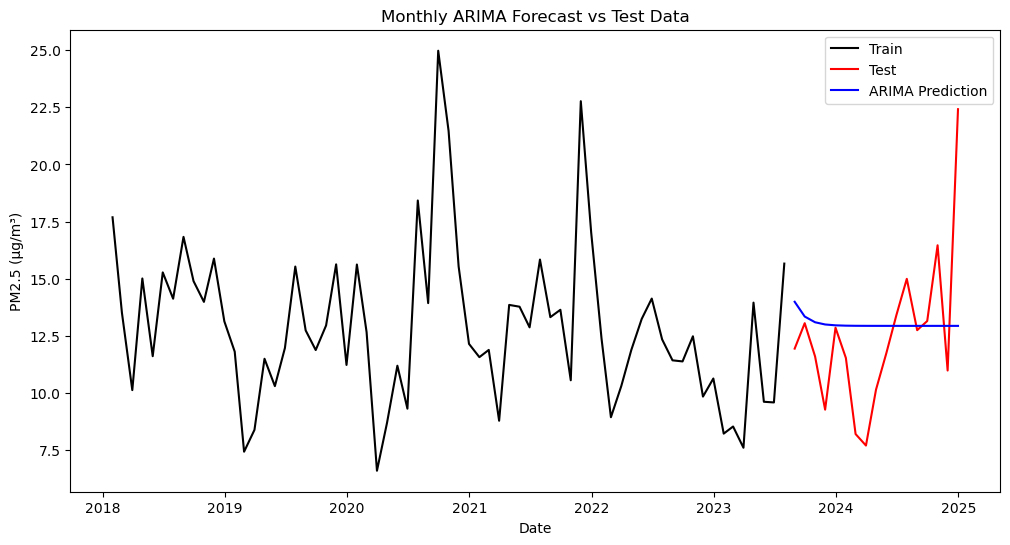

In [72]:
# Daily plot
plt.figure(figsize=(12,6))
plt.plot(train_daily.index, train_daily['PM2.5'], label='Train', color='black')
plt.plot(test_daily.index, test_daily['PM2.5'], label='Test', color='red')
plt.plot(test_daily.index, pred_daily, label='ARIMA Prediction', color='blue')
plt.title('Daily ARIMA Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

# Monthly plot
plt.figure(figsize=(12,6))
plt.plot(train_monthly.index, train_monthly['PM2.5'], label='Train', color='black')
plt.plot(test_monthly.index, test_monthly['PM2.5'], label='Test', color='red')
plt.plot(test_monthly.index, pred_monthly, label='ARIMA Prediction', color='blue')
plt.title('Monthly ARIMA Forecast vs Test Data')
plt.xlabel('Date')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()


# Machine Learning

In [73]:
# -------------------------------
#Create lag features
# -------------------------------
def create_lag_features(series, lag=3):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

lag_days = 3 

# Daily
X_train_daily, y_train_daily = create_lag_features(train_daily['PM2.5'].values, lag=lag_days)
X_test_daily, y_test_daily = create_lag_features(
    np.concatenate([train_daily['PM2.5'].values[-lag_days:], test_daily['PM2.5'].values]), lag=lag_days
)

# Monthly
X_train_monthly, y_train_monthly = create_lag_features(train_monthly['PM2.5'].values, lag=lag_days)
X_test_monthly, y_test_monthly = create_lag_features(
    np.concatenate([train_monthly['PM2.5'].values[-lag_days:], test_monthly['PM2.5'].values]), lag=lag_days
)

# -------------------------------
# LSTM requires 3D input
# -------------------------------
X_train_daily_lstm = X_train_daily.reshape((X_train_daily.shape[0], X_train_daily.shape[1], 1))
X_test_daily_lstm  = X_test_daily.reshape((X_test_daily.shape[0], X_test_daily.shape[1], 1))

X_train_monthly_lstm = X_train_monthly.reshape((X_train_monthly.shape[0], X_train_monthly.shape[1], 1))
X_test_monthly_lstm  = X_test_monthly.reshape((X_test_monthly.shape[0], X_test_monthly.shape[1], 1))


In [74]:
# -------------------------------
# LSTM Model
# -------------------------------
def train_lstm(X_train, y_train, X_test, y_test, epochs=50, batch_size=16):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    
    y_pred = model.predict(X_test, verbose=0)
    return y_pred.flatten()

# Daily LSTM
y_pred_daily_lstm = train_lstm(X_train_daily_lstm, y_train_daily, X_test_daily_lstm, y_test_daily)
# Monthly LSTM
y_pred_monthly_lstm = train_lstm(X_train_monthly_lstm, y_train_monthly, X_test_monthly_lstm, y_test_monthly)

c:\Users\Bjqhm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[codecarbon INFO @ 20:45:32] Energy consumed for RAM : 0.000048 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:32] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:32] Energy consumed for All CPU : 0.000105 kWh
[codecarbon INFO @ 20:45:32] 0.000153 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:33] Energy consumed for RAM : 0.000054 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:33] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:33] Energy consumed for All CPU : 0.000117 kWh
[codecarbon INFO @ 20:45:33] 0.000170 kWh of electricity used since the beginning.
[codecarbon INFO 

In [75]:
# -------------------------------
# Random Forest
# -------------------------------
def train_rf(X_train, y_train, X_test):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf.predict(X_test)

y_pred_daily_rf = train_rf(X_train_daily, y_train_daily, X_test_daily)
y_pred_monthly_rf = train_rf(X_train_monthly, y_train_monthly, X_test_monthly)

[codecarbon INFO @ 20:45:46] Energy consumed for RAM : 0.000128 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:46] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:46] Energy consumed for All CPU : 0.000275 kWh
[codecarbon INFO @ 20:45:46] 0.000402 kWh of electricity used since the beginning.


In [76]:
# -------------------------------
# XGBoost
# -------------------------------
def train_xgb(X_train, y_train, X_test):
    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb.fit(X_train, y_train)
    return xgb.predict(X_test)

y_pred_daily_xgb = train_xgb(X_train_daily, y_train_daily, X_test_daily)
y_pred_monthly_xgb = train_xgb(X_train_monthly, y_train_monthly, X_test_monthly)


[codecarbon INFO @ 20:45:47] Energy consumed for RAM : 0.000133 kWh. RAM Power : 20.0 W


In [77]:
# -------------------------------
# Performance metrics
# -------------------------------
def evaluate(y_true, y_pred, label=""):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_val = mean_absolute_error(y_true, y_pred)
    mape_val = np.mean(np.abs((y_true - y_pred)/y_true))
    print(f"{label} RMSE: {rmse_val:.3f} | MAE: {mae_val:.3f} | MAPE: {mape_val:.3f}")

# Daily
evaluate(y_test_daily, y_pred_daily_lstm, "Daily LSTM")
evaluate(y_test_daily, y_pred_daily_rf, "Daily RF")
evaluate(y_test_daily, y_pred_daily_xgb, "Daily XGB")

# Monthly
evaluate(y_test_monthly, y_pred_monthly_lstm, "Monthly LSTM")
evaluate(y_test_monthly, y_pred_monthly_rf, "Monthly RF")
evaluate(y_test_monthly, y_pred_monthly_xgb, "Monthly XGB")

[codecarbon INFO @ 20:45:47] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:47] Energy consumed for All CPU : 0.000286 kWh
[codecarbon INFO @ 20:45:47] 0.000420 kWh of electricity used since the beginning.


Daily LSTM RMSE: 4.652 | MAE: 3.089 | MAPE: 0.282
Daily RF RMSE: 4.841 | MAE: 3.327 | MAPE: 0.308
Daily XGB RMSE: 4.959 | MAE: 3.307 | MAPE: 0.305
Monthly LSTM RMSE: 3.416 | MAE: 2.887 | MAPE: 0.236
Monthly RF RMSE: 2.942 | MAE: 2.147 | MAPE: 0.171
Monthly XGB RMSE: 2.803 | MAE: 2.019 | MAPE: 0.158


[codecarbon INFO @ 20:45:47] 0.006321 g.CO2eq/s mean an estimation of 199.35199317495517 kg.CO2eq/year


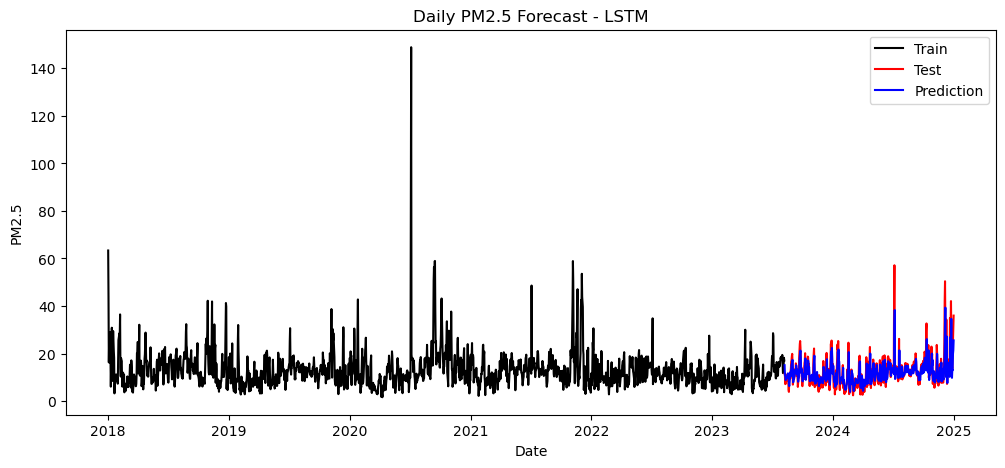

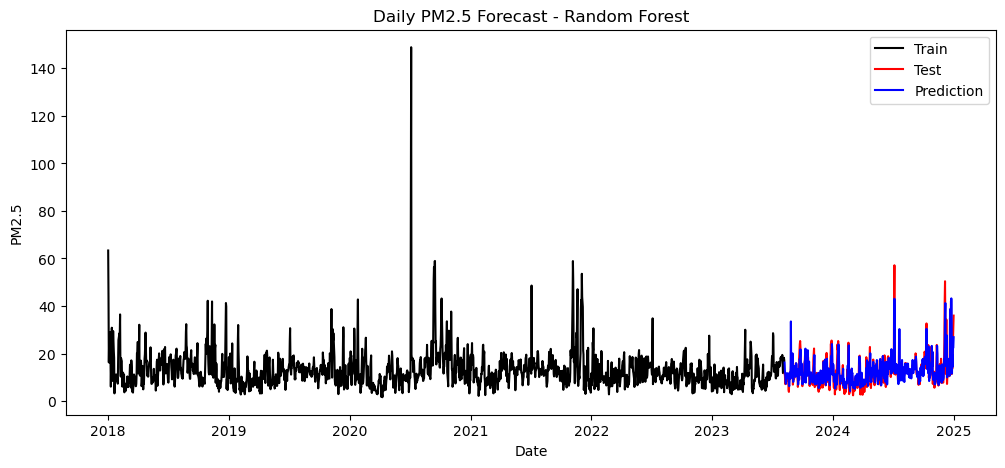

[codecarbon INFO @ 20:45:48] Energy consumed for RAM : 0.000139 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:48] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:48] Energy consumed for All CPU : 0.000298 kWh
[codecarbon INFO @ 20:45:48] 0.000437 kWh of electricity used since the beginning.


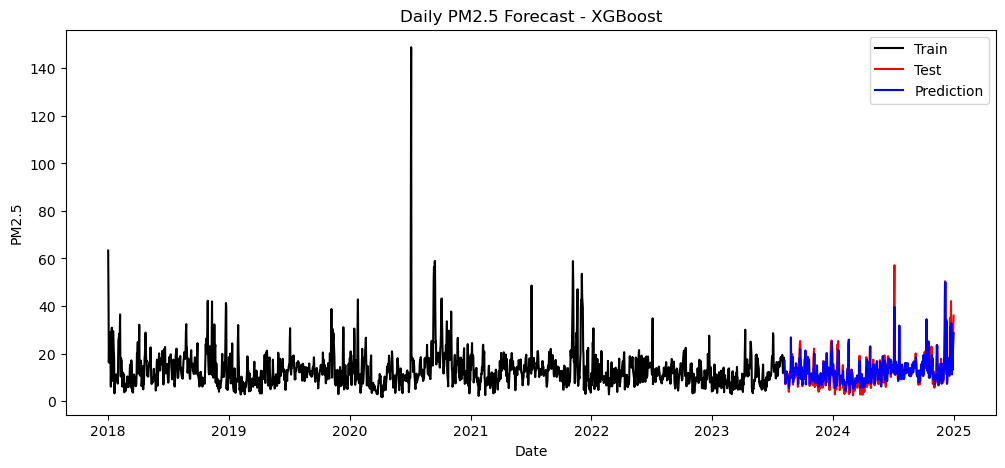

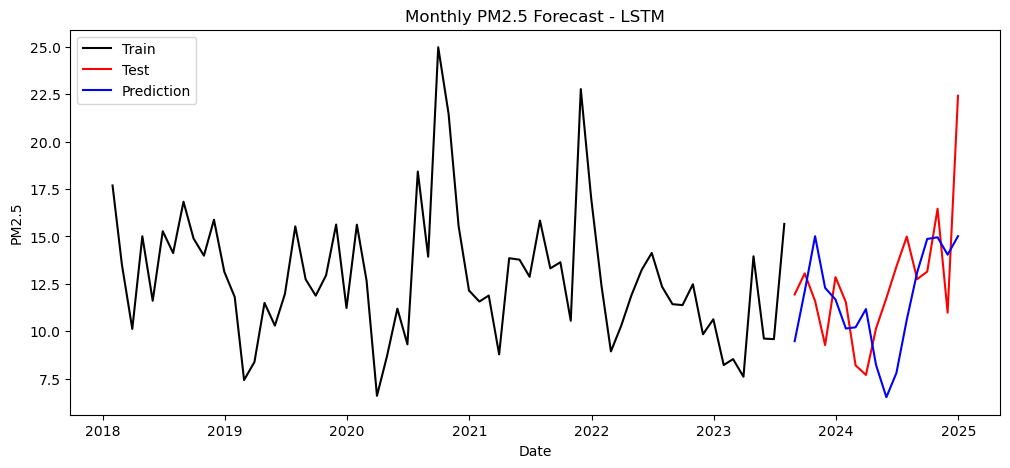

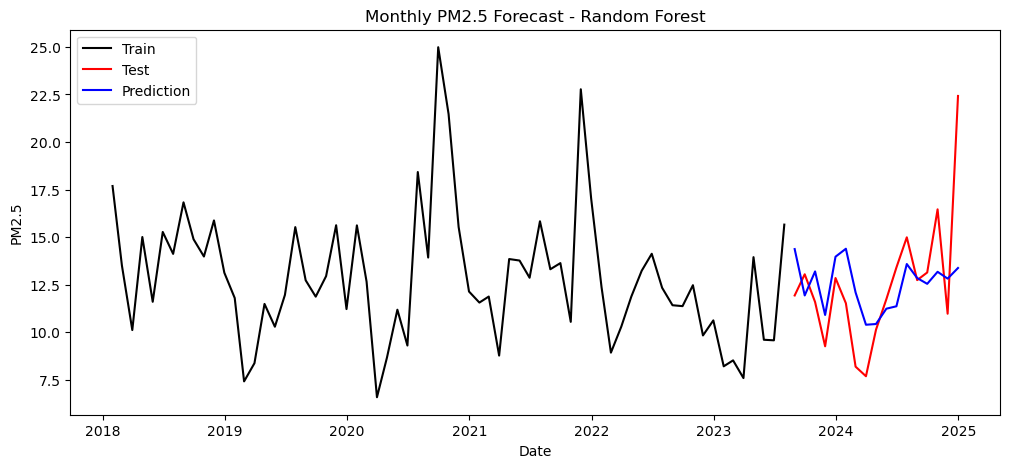

[codecarbon INFO @ 20:45:49] Energy consumed for RAM : 0.000144 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:49] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:49] Energy consumed for All CPU : 0.000310 kWh
[codecarbon INFO @ 20:45:49] 0.000454 kWh of electricity used since the beginning.


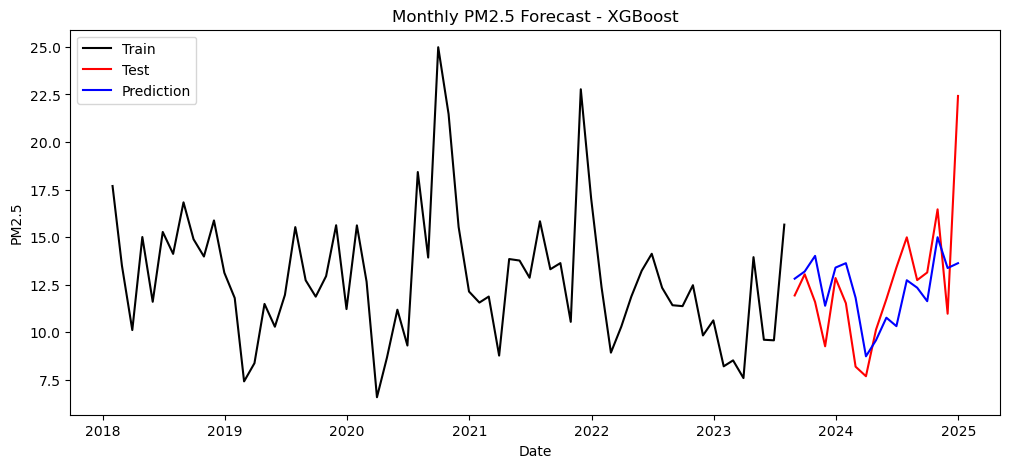

[codecarbon INFO @ 20:45:50] Energy consumed for RAM : 0.000150 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:50] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:50] Energy consumed for All CPU : 0.000322 kWh
[codecarbon INFO @ 20:45:50] 0.000472 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:51] Energy consumed for RAM : 0.000155 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:51] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:51] Energy consumed for All CPU : 0.000334 kWh
[codecarbon INFO @ 20:45:51] 0.000489 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:45:52] Energy consumed for RAM : 0.000161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:45:52] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 20:45:52] Energy consumed for All CPU : 0.000345 kWh
[codecarbon INFO @ 20:45:52] 0.000506 kWh 

In [ ]:
def plot_forecast(train_series, test_series, y_pred, title="Forecast", xlabel="Date", ylabel="PM2.5"):
    """
    train_series: pd.Series, training data
    test_series: pd.Series, testing data 
    y_pred: np.array, predicted values,长度与test_series一致
    """
    plt.figure(figsize=(12,5))
    plt.plot(train_series.index, train_series.values, color='black', label='Train')
    plt.plot(test_series.index, test_series.values, color='red', label='Test')
    plt.plot(test_series.index, y_pred, color='blue', label='Prediction')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# -------------------------------
# Daily LSTM
plot_forecast(train_daily['PM2.5'], test_daily['PM2.5'], y_pred_daily_lstm, title="Daily PM2.5 Forecast - LSTM")

# Daily Random Forest
plot_forecast(train_daily['PM2.5'], test_daily['PM2.5'], y_pred_daily_rf, title="Daily PM2.5 Forecast - Random Forest")

# Daily XGBoost
plot_forecast(train_daily['PM2.5'], test_daily['PM2.5'], y_pred_daily_xgb, title="Daily PM2.5 Forecast - XGBoost")

# -------------------------------
# Monthly LSTM
plot_forecast(train_monthly['PM2.5'], test_monthly['PM2.5'], y_pred_monthly_lstm, title="Monthly PM2.5 Forecast - LSTM")

# Monthly Random Forest
plot_forecast(train_monthly['PM2.5'], test_monthly['PM2.5'], y_pred_monthly_rf, title="Monthly PM2.5 Forecast - Random Forest")

# Monthly XGBoost
plot_forecast(train_monthly['PM2.5'], test_monthly['PM2.5'], y_pred_monthly_xgb, title="Monthly PM2.5 Forecast - XGBoost")


In [79]:
tracker.stop()

[codecarbon INFO @ 20:46:17] Energy consumed for RAM : 0.000300 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 20:46:17] Delta energy consumed for CPU with constant : 0.000001 kWh, power : 42.5 W
[codecarbon INFO @ 20:46:17] Energy consumed for All CPU : 0.000643 kWh
[codecarbon INFO @ 20:46:17] 0.000943 kWh of electricity used since the beginning.


0.0003479514538593544